<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/rnn_intent_classifier/rnn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

# Example usage
file_path = "data.txt"  # Replace with the path to your dataset file
dataset = read_dataset(file_path)
print(dataset[:10])

[('Intent', 'Example'), ('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there')]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the dataset
training_data = dataset

# Define the vocabulary
all_chars = set(''.join([sentence for intent, sentence in training_data]))
char_to_index = {char: i for i, char in enumerate(all_chars)}
index_to_char = {i: char for char, i in char_to_index.items()}
num_chars = len(all_chars)

all_intents = set(intent for intent, _ in training_data)
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {i: intent for intent, i in intent_to_index.items()}
num_intents = len(all_intents)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert sentences to tensors
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, num_chars).to(device)
    for i, char in enumerate(sentence):
        tensor[i][0][char_to_index[char]] = 1
    return tensor

# Convert intents to tensors
def intent_to_tensor(intent):
    return torch.tensor([intent_to_index[intent]], dtype=torch.long).to(device)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [6]:
# optim.lr_scheduler.ExponentialLR
import torch.optim as optim


Epoch 10/100, Loss: 691.8052645921707
Epoch 20/100, Loss: 632.3695509433746
Epoch 30/100, Loss: 605.4352175593376
Epoch 40/100, Loss: 594.1335757374763
Epoch 50/100, Loss: 588.2165080308914
Epoch 60/100, Loss: 586.0003904700279
Epoch 70/100, Loss: 585.1318122148514
Epoch 80/100, Loss: 584.8166472911835
Epoch 90/100, Loss: 584.7051454782486
Epoch 100/100, Loss: 584.6663357019424


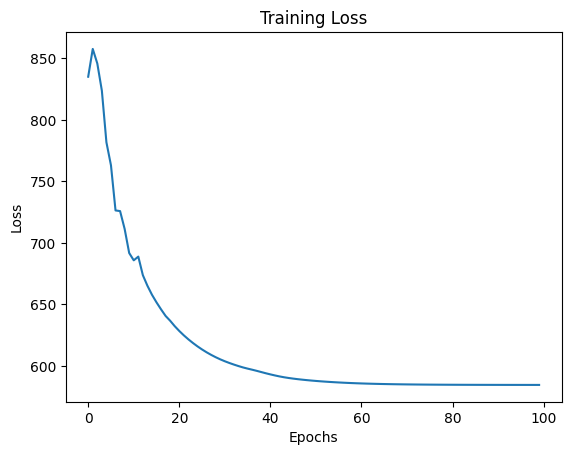

In [10]:
# Define hyperparameters
hidden_size = 128
learning_rate = 0.001
epochs = 100

# Initialize the model
model = RNN(num_chars, hidden_size, num_intents)
model.to(device)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop with loss plotting
losses = []
for epoch in range(epochs):
    total_loss = 0
    for intent, sentence in training_data:
        model.zero_grad()
        intent_tensor = intent_to_tensor(intent)
        sentence_tensor = sentence_to_tensor(sentence)
        output = model(sentence_tensor)
        loss = loss_function(output, intent_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    losses.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [19]:

def train_rnn(model, training_data, intent_to_tensor, sentence_to_tensor, device, hidden_size, learning_rate, epochs):

    # Initialize the model
    model = model(num_chars, hidden_size, num_intents)
    model.to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training loop with loss plotting
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for intent, sentence in training_data:
            model.zero_grad()
            intent_tensor = intent_to_tensor(intent)
            sentence_tensor = sentence_to_tensor(sentence)
            output = model(sentence_tensor)
            loss = loss_function(output, intent_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        losses.append(total_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

    # Plot the loss
    # plt.plot(losses)
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Training Loss')
    # plt.show()

    return losses

In [39]:
losses_container = []
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
num = len(learning_rates)
for i in range(num):
  loss_arr = train_rnn(
    model=RNN,
    training_data=training_data,
    intent_to_tensor=intent_to_tensor,
    sentence_to_tensor=sentence_to_tensor,
    device=device,
    hidden_size=128,
    learning_rate=learning_rates[i],
    epochs=100
  )
  losses_container.append(loss_arr)


Epoch 10/100, Loss: 635.7810689806938
Epoch 20/100, Loss: 542.1506969630718
Epoch 30/100, Loss: 486.9949531853199
Epoch 40/100, Loss: 443.689174965024
Epoch 50/100, Loss: 422.6954416334629
Epoch 60/100, Loss: 415.44838723540306
Epoch 70/100, Loss: 412.94185864925385
Epoch 80/100, Loss: 412.0721254646778
Epoch 90/100, Loss: 411.76969215273857
Epoch 100/100, Loss: 411.6645596474409
Epoch 10/100, Loss: 578.7695207446814
Epoch 20/100, Loss: 591.3597867786884
Epoch 30/100, Loss: 552.1558736115694
Epoch 40/100, Loss: 511.20629969239235
Epoch 50/100, Loss: 492.9063786417246
Epoch 60/100, Loss: 484.17685398459435
Epoch 70/100, Loss: 481.3233425319195
Epoch 80/100, Loss: 480.27898336946964
Epoch 90/100, Loss: 479.9168784022331
Epoch 100/100, Loss: 479.7923324108124
Epoch 10/100, Loss: 849.2280732877553
Epoch 20/100, Loss: 709.9035401772708
Epoch 30/100, Loss: 621.4993703467771
Epoch 40/100, Loss: 597.3809582535177
Epoch 50/100, Loss: 580.7591964956373
Epoch 60/100, Loss: 577.6299448106438
Epoch

In [26]:
losses_container

[[851.4442416215315,
  784.4177997224033,
  783.896438755095,
  762.4706983044744,
  748.2793019413948],
 [1033.8024413281382,
  952.7936688661575,
  891.5682371258736,
  871.6830251663923,
  820.5867783725262],
 [1330.1041737829569,
  1108.1884707836434,
  1060.7881167107262,
  1030.2419132082723,
  964.9471409386024],
 [3730.9121730530305,
  2229.0053654265157,
  2079.313133320182,
  1830.0120957691556,
  1690.0801138664192],
 [6273.782479118247,
  6553.588085675044,
  6364.778241495245,
  6051.948942370655,
  5197.935652381405],
 [23776.382195529153,
  21683.943885719946,
  19861.218762247787,
  17004.030948443335,
  14337.002806204287]]

<ipython-input-40-eb852f5d2884>:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.5, hspace=0.5)


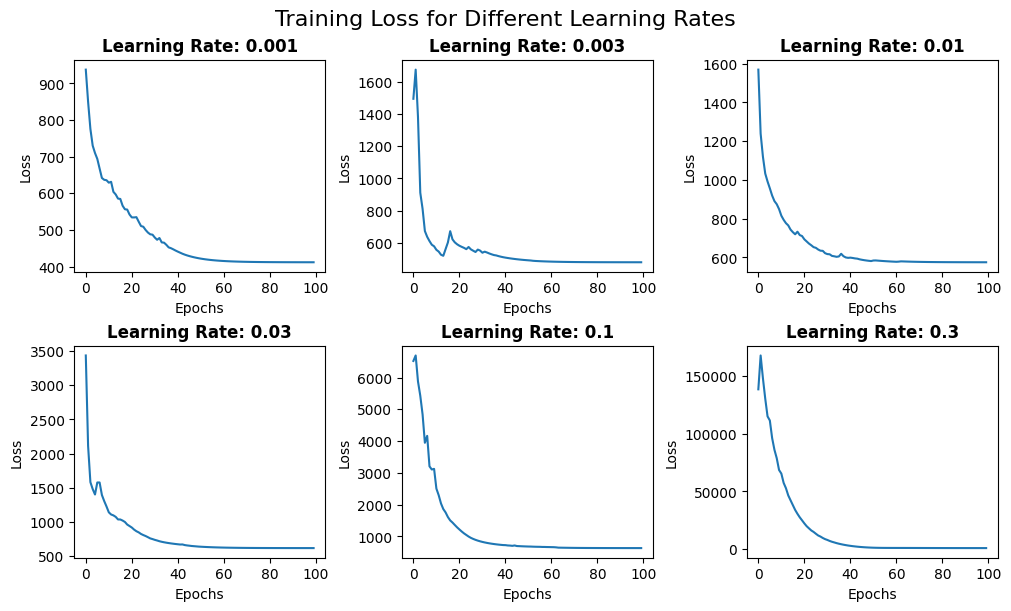

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Training Loss for Different Learning Rates', fontsize=16)

for i in range(2):
    for j in range(3):
        ax[i][j].plot(losses_container[i * 3 + j])
        ax[i][j].set_title(f'Learning Rate: {learning_rates[i * 3 + j]}', fontsize=12, fontweight='bold')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel('Loss')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [16]:
# Test the model
def predict_intent(sentence):
    with torch.no_grad():
        output = model(sentence_to_tensor(sentence))
        _, predicted_index = torch.max(output, 1)
        predicted_intent = index_to_intent[predicted_index.item()]
        return predicted_intent

# Example usage
test_sentence = "How are you?"
print("Predicted intent:", predict_intent(test_sentence))

Predicted intent: Inquiry


In [14]:
# all_intents

In [ ]:
# char_to_index.items()

dict_items([('l', 0), ('R', 1), ('q', 2), ('m', 3), ('B', 4), ('U', 5), ('C', 6), ('w', 7), ('e', 8), ('o', 9), ('h', 10), ('p', 11), ('T', 12), ('v', 13), ('L', 14), ('F', 15), ('n', 16), ('S', 17), ('P', 18), ('-', 19), ('b', 20), ('i', 21), ('G', 22), ('2', 23), ('.', 24), ('u', 25), ('g', 26), ('j', 27), ('c', 28), ('E', 29), ('W', 30), ('x', 31), ('N', 32), ('f', 33), ('O', 34), ('r', 35), ('z', 36), ('a', 37), ('t', 38), ('k', 39), ('?', 40), (' ', 41), ('y', 42), ('Y', 43), ('I', 44), ('s', 45), ('7', 46), ('H', 47), ('A', 48), ('"', 49), ("'", 50), ('d', 51), ('M', 52), ('!', 53)])